# Reinforce (Monte Carlo Policy Gradient) Method

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
plt.style.use('ggplot')

## Set Configs

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [5]:
GAMMA = 1.0
PRINT_EVERY = 100
LR = 1e-2

## Set Environment

In [6]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(4,)
Action space Discrete(2)


## Define The Policy

In [8]:
class PolicyNetwork(nn.Module):
    """Define non-linear Policy."""
    
    def __init__(self, env, seed, hidden_size=16):
        
        super(PolicyNetwork, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        
        self.fc1_layer = nn.Linear(state_size, hidden_size)
        self.fc2_layer = nn.Linear(hidden_size, action_size)
    
    def act(self, state):
        
        state = torch.from_numpy(state).float().unsqueeze(0)
        state = state.to(device)
        
        probs = self.forward(state)
        m = Categorical(probs.cpu())
        
        action = m.sample()
        log_prob = -m.log_prob(action) # negative sign comes from pytorch
                
        return action.item(), log_prob
    
    def forward(self, x):
        
        x = F.relu(self.fc1_layer(x))
        logits = self.fc2_layer(x)
        probs = F.softmax(logits, dim=1) # use softmax for discrete action spaces
        
        return probs

In [9]:
policy = PolicyNetwork(env, seed=90).to(device)

## Set Optimizer

In [10]:
optimizer = optim.Adam(policy.parameters(), lr=LR)

## Train The Agent

In [11]:
def train_agent(num_episodes=1000, max_time=1000, gamma=1.0):
    
    scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, num_episodes+1):
        
        state = env.reset()
        
        saved_log_probs = []
        rewards = []
        
        for time in range(max_time):
            
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            
            next_state, reward, done, _ = env.step(action)
            
            state = next_state
            rewards.append(reward)
            if done:
                break
                
        scores_window.append(sum(rewards))
        scores.append(sum(rewards))
        
        optimizer.zero_grad()
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)]) # Monte-Carlo estimate as a baseline
        
        # log of the action probabilities for policy gradient calculation
        # consolidates information from trajectories to yield an estimate for the gradient
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(log_prob * R)
        
        policy_loss = torch.cat(policy_loss).sum()
        
        policy_loss.backward() # calculates gradient by collecting m=1 (try more to get better performance)
        optimizer.step()
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 120.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            break
            
    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(policy.state_dict(), f'./agents/REINFORCE_{ENV_NAME}.pth')
    print('Training completed.')
    
    return scores

In [12]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: 34.69
Episode: 200, Average Score: 66.60
Episode: 247, Average Score: 122.05
Environment solved in 147 episodes! Average Score: 122.05
Training completed.


## Evaluate The Agent

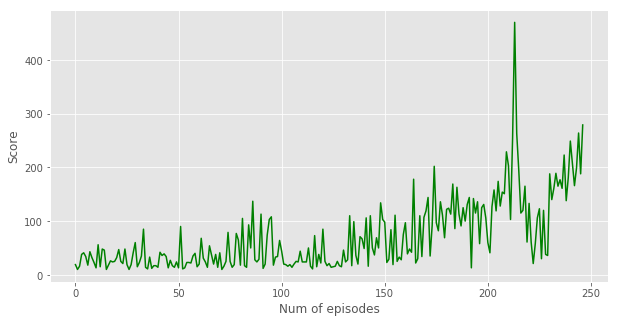

In [13]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_reinforce_policy_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [14]:
# load the weights of smart agent
policy.load_state_dict(torch.load(f'./agents/REINFORCE_{ENV_NAME}.pth'));

In [15]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(1000):
        
        env.render() # render the screen
        
        action, _ = policy.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

Episode: 1, Average Score: 173.00
Episode: 2, Average Score: 134.00
Episode: 3, Average Score: 230.00
Episode: 4, Average Score: 232.00
Episode: 5, Average Score: 534.00


---